In [120]:
import warnings
warnings.filterwarnings("ignore")
import os, re
import copy
from typing import Iterable, List
from tqdm import tqdm
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator

from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
data = pd.read_csv("text_generation.csv")
data.sample(5)

,PLAYER_GATE_ID,GAME_NAME,RAPIDO_IND,ROCKET_IND,V36_IND,ZHL_IND,VIN_IND,VII49_IND,IV20_IND,BIGSPORT_IND,...,RL_IND,DUEL_IND,SPECGAME_IND,RAPIDO2_IND,TOP3_IND,ZABAVA_IND,KENO_IND,BINGO75_IND,VI36_IND,ZP_IND
59477,769957111200,russianlot russianlot russianlot russianlot ru...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
378586,9949467400200,russianlot zhilot russianlot zhilot russianlot...,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3820,129018900,vin vin vin vin vin vin vin russianlot fourtw ...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
249844,5357101464800,rapido rapido rapido vin vin vin vin vin bigsp...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204747,4929104619700,fourtw russianlot russianlot russianlot russia...,1,1,0,1,1,0,1,0,...,1,0,0,1,1,1,0,0,0,1


<Axes: >

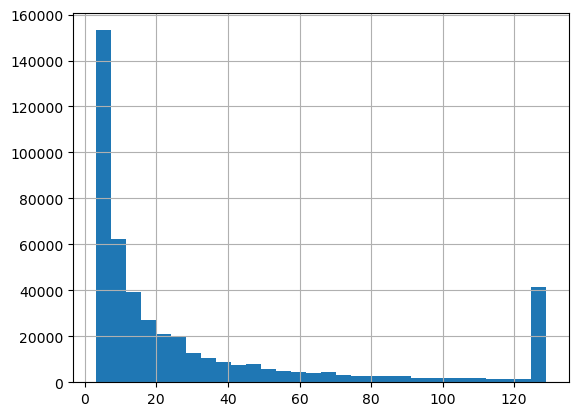

In [13]:
data["GAME_NAME"].apply(word_tokenize).apply(len).hist(bins=30)

In [14]:
data["GAME_NAME"].apply(word_tokenize).apply(len).describe()

count    462543.000000
mean         31.019871
std          38.637366
min           3.000000
25%           6.000000
50%          13.000000
75%          37.000000
max         129.000000
Name: GAME_NAME, dtype: float64

In [5]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

In [6]:
def yield_tokens(data_iter):
    data_iter = data_iter["GAME_NAME"].values
    for data_sample in data_iter:
        yield word_tokenize(data_sample)

In [7]:
vocab_transform = build_vocab_from_iterator(yield_tokens(data),
                                            min_freq=1,
                                            specials=special_symbols,
                                            special_first=True)

In [8]:
vocab_transform.set_default_index(UNK_IDX)

In [9]:
class TransDataset(Dataset):
    def __init__(self, data, is_train=True):
        train, test = train_test_split(data, shuffle=True, random_state=42)
        if is_train:
            self.data = train
        else:
            self.data = test

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        text = self.data["GAME_NAME"].iloc[ix]
        text = word_tokenize(text)
        if len(text) > 127:
            text = text[-127:]
        source, target = ' '.join(text[1:]), ' '.join(text[:-1])
        return source, target

    def collate_fn(self, batch):
        src_batch, tgt_batch = [], []

        for src_sample, tgt_sample in batch:
            src_batch.append(text_transform(src_sample))
            tgt_batch.append(text_transform(tgt_sample))

        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)  # if error -> pad by: + [PAD_IDX]*(max_len-len(text))
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
        return src_batch, tgt_batch

In [52]:
# TODO: split text with chunks, so that we increase the number of samples (now we predict next tokens basing on all previous)
def get_batch(data: list[str], block_size: int, batch_size: int):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    # y is x shifted one position right - because we predict
    # word in y having all the previous words as context
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y

In [10]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = sequential_transforms(word_tokenize,  # Tokenization
                                       vocab_transform,  # Numericalization
                                       tensor_transform)

In [11]:
batch_size = 32
train_ds = TransDataset(data, is_train=True)
valid_ds = TransDataset(data, is_train=False)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, collate_fn=valid_ds.collate_fn)

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * np.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [13]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)

In [14]:
def create_trg_mask(size):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype("uint8")
    np_mask = (torch.from_numpy(np_mask) == 0.0).to(device)
    return np_mask

def create_masks(src, trg):
    
    src_mask = (src != PAD_IDX).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != PAD_IDX).unsqueeze(-2)
        size = trg.size(1) 
        np_mask = create_trg_mask(size)
        trg_mask = trg_mask & np_mask
    else:
        trg_mask = None
        
    return src_mask, trg_mask

In [15]:
def attention(query, key, value, d_model, mask=None, dropout=None):
    
    scores = torch.einsum("... i d , ... j d -> ... i j", query, key) / np.sqrt(d_model)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)  # mask padding
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.einsum("... i j , ... j d -> ... i d", scores, value)
    
    return output

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.heads = heads
        
        self.q_linear = nn.Linear(d_model, d_model, bias=False)
        self.v_linear = nn.Linear(d_model, d_model, bias=False)
        self.k_linear = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, q, k, v, mask=None):
        
        batch_size = q.size(0)

        k = self.k_linear(k).view(batch_size, -1, self.heads, self.d_k)
        q = self.q_linear(q).view(batch_size, -1, self.heads, self.d_k)
        v = self.v_linear(v).view(batch_size, -1, self.heads, self.d_k)
               
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        concat = scores.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

In [17]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=512, dropout=0.1):
        super(FeedForward, self).__init__() 
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.dropout(F.gelu(self.linear_1(x)))  # or "gelu": [x * scipy.stats.norm.cdf(x, loc=0, scale=1)]
        x = self.linear_2(x)
        return x

In [18]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
    
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

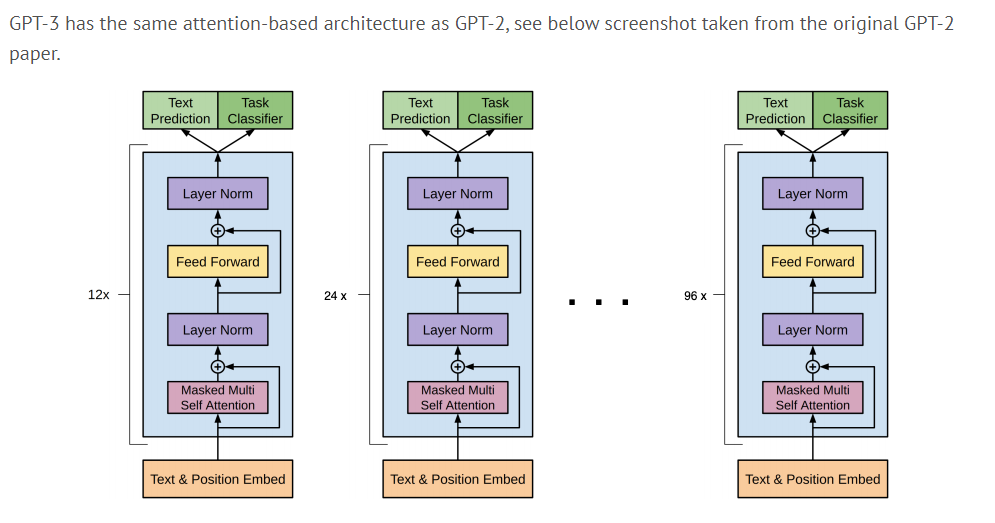

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.norm_1 = LayerNorm(d_model)
        self.norm_2 = LayerNorm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
        self.mha = MultiHeadAttention(heads, d_model)
        self.ffn = FeedForward(d_model)
        
    def forward(self, x, trg_mask):  # mask: tgt + pad
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.mha(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x2 = x2 + self.dropout_2(self.ffn(x2))
        return x

In [20]:
def get_n_layers(module, n_layers):
    return nn.ModuleList([copy.deepcopy(module) for i in range(n_layers)])

In [21]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, heads):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.embedding = TokenEmbedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, dropout=0.1)
        self.layers = get_n_layers(DecoderLayer(d_model, heads), n_layers)
        self.norm = LayerNorm(d_model)
        
    def forward(self, trg, trg_mask):
        x = self.embedding(trg)
        x = self.pe(x)
        for i in range(self.n_layers):
            x = self.layers[i](x, trg_mask)
        return self.norm(x)

In [22]:
class Model(nn.Module):
    def __init__(self, vocab, d_model, n_layers, heads):
        super(Model, self).__init__()
        self.decoder = Decoder(vocab, d_model, n_layers, heads)
        self.out = nn.Linear(d_model, vocab)
        
    def forward(self, trg, trg_mask):
        decoder_out = self.decoder(trg, trg_mask)
        output = self.out(decoder_out)
        return output

In [23]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path="model.pth"):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            if model is not None:
                checkpoint = {
                    "model": model,
                }
                torch.save(checkpoint, self.path)
                print(f"Model saved to: {self.path}")
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print("INFO: Early stopping")
                self.early_stop = True

In [24]:
vocab = len(vocab_transform)
d_model = 128
heads = 8
batch_size = 32
n_layers = 3

model = Model(vocab, d_model, n_layers, heads).to(device)
early = EarlyStopping(patience=3)

In [25]:
for param in model.parameters():
    if param.dim() > 1:
        nn.init.xavier_uniform_(param)
        
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.5)

In [26]:
# TODO

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader, total=len(train_dataloader)):  #  text[1:], text[:-1]
        src = src.transpose(0, 1).to(device)
        tgt = tgt.transpose(0, 1).to(device)

        tgt_out = src.contiguous().view(-1)

        _, tgt_mask = create_masks(src, tgt)

        logits = model(tgt, tgt_mask)

        optimizer.zero_grad()
        
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out)
        loss.backward()

        optimizer.step()
        losses += loss.item()
    scheduler.step()
    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0    

    for src, tgt in tqdm(valid_dataloader, total=len(valid_dataloader)):
        src = src.transpose(0, 1).to(device)
        tgt = tgt.transpose(0, 1).to(device)

        tgt_out = src.contiguous().view(-1)

        _, tgt_mask = create_masks(src, tgt)

        logits = model(tgt, tgt_mask)
        
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out)
        losses += loss.item()

    return losses / len(valid_dataloader)

In [27]:
NUM_EPOCHS = 50
        
for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_epoch(model, optimizer)
    val_loss = evaluate(model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}"))
    early(val_loss, model)
    if early.early_stop:
        break

100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:12<00:00, 49.66it/s]


Epoch: 1, Train loss: 1.1254, Val loss: 1.0635


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:21<00:00, 44.39it/s]


Epoch: 2, Train loss: 1.0732, Val loss: 1.0546
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.39it/s]


Epoch: 3, Train loss: 1.0637, Val loss: 1.0493
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.02it/s]


Epoch: 4, Train loss: 1.0586, Val loss: 1.0468
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.43it/s]


Epoch: 5, Train loss: 1.0560, Val loss: 1.0463
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:18<00:00, 46.30it/s]


Epoch: 6, Train loss: 1.0531, Val loss: 1.0438
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:17<00:00, 46.58it/s]


Epoch: 7, Train loss: 1.0512, Val loss: 1.0443
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.49it/s]


Epoch: 8, Train loss: 1.0492, Val loss: 1.0405
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:15<00:00, 47.58it/s]


Epoch: 9, Train loss: 1.0483, Val loss: 1.0417
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.28it/s]


Epoch: 10, Train loss: 1.0478, Val loss: 1.0396
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.33it/s]


Epoch: 11, Train loss: 1.0453, Val loss: 1.0359
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.41it/s]


Epoch: 12, Train loss: 1.0450, Val loss: 1.0408
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:15<00:00, 47.61it/s]


Epoch: 13, Train loss: 1.0447, Val loss: 1.0362
INFO: Early stopping counter 2 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.27it/s]


Epoch: 14, Train loss: 1.0436, Val loss: 1.0356
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.11it/s]


Epoch: 15, Train loss: 1.0441, Val loss: 1.0350
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.27it/s]


Epoch: 16, Train loss: 1.0434, Val loss: 1.0371
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.25it/s]


Epoch: 17, Train loss: 1.0426, Val loss: 1.0348
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.19it/s]


Epoch: 18, Train loss: 1.0431, Val loss: 1.0353
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.28it/s]


Epoch: 19, Train loss: 1.0419, Val loss: 1.0343
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.32it/s]


Epoch: 20, Train loss: 1.0423, Val loss: 1.0338
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.12it/s]


Epoch: 21, Train loss: 1.0415, Val loss: 1.0334
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.26it/s]


Epoch: 22, Train loss: 1.0412, Val loss: 1.0349
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.15it/s]


Epoch: 23, Train loss: 1.0402, Val loss: 1.0329
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:17<00:00, 46.59it/s]


Epoch: 24, Train loss: 1.0401, Val loss: 1.0329
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.19it/s]


Epoch: 25, Train loss: 1.0401, Val loss: 1.0328
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.16it/s]


Epoch: 26, Train loss: 1.0396, Val loss: 1.0329
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.14it/s]


Epoch: 27, Train loss: 1.0397, Val loss: 1.0331
INFO: Early stopping counter 2 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 46.98it/s]


Epoch: 28, Train loss: 1.0400, Val loss: 1.0326
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.05it/s]


Epoch: 29, Train loss: 1.0395, Val loss: 1.0326
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 46.98it/s]


Epoch: 30, Train loss: 1.0399, Val loss: 1.0323
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:17<00:00, 46.87it/s]


Epoch: 31, Train loss: 1.0392, Val loss: 1.0323
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.04it/s]


Epoch: 32, Train loss: 1.0389, Val loss: 1.0319
Model saved to: model.pth


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.16it/s]


Epoch: 33, Train loss: 1.0390, Val loss: 1.0320
INFO: Early stopping counter 1 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:16<00:00, 47.10it/s]


Epoch: 34, Train loss: 1.0390, Val loss: 1.0331
INFO: Early stopping counter 2 of 3


100%|██████████████████████████████████████████████████████████████████████████████| 3614/3614 [01:17<00:00, 46.87it/s]

Epoch: 35, Train loss: 1.0385, Val loss: 1.0320
INFO: Early stopping counter 3 of 3
INFO: Early stopping


In [32]:
model = torch.load("model.pth")["model"].to(device)

In [92]:
# TODO: give context [few first tokens] - start_symbols - tokenized inputs, add temperature
def greedy_decode(model, start_symbols, max_len=50, temperature=1.0, greedy=True, topk=3):
    ys = torch.LongTensor(start_symbols).to(device)

    for i in range(max_len-1):
        tgt_mask = create_trg_mask(ys.size(1)).type(torch.bool)
        output = model.decoder(ys, tgt_mask)
        prob = model.out(output[:, -1])
        prob = torch.exp(prob/temperature) / torch.sum(torch.exp(prob/temperature))
        if greedy:
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()
        else:
            next_words = torch.topk(prob, topk, dim=1).indices
            next_words = next_words.detach().cpu().numpy()
            next_word = int(np.random.choice(next_words.ravel()))
        if next_word == EOS_IDX:
            break
        ys = torch.cat([ys, torch.ones(1, 1).type_as(ys.data).fill_(next_word)], dim=1)

    return ys[:, start_symbols.size(1):]  # sequence of predictions, a tensor of integers

In [116]:
@torch.no_grad()
def predict(text, model, max_len=50, temperature=1.0, greedy=True, topk=3, unique=True):  # text latest sales history
    model.eval()
    
    start_symbols = text_transform(text)[:-1].view(-1, 1)
    start_symbols = start_symbols.transpose(0, 1)

    tgt_tokens = greedy_decode(model, 
                               start_symbols, 
                               max_len=max_len, 
                               temperature=temperature, 
                               greedy=greedy, 
                               topk=topk).flatten()
    result = " ".join(vocab_transform.lookup_tokens(list(tgt_tokens.cpu().numpy())))
    if unique:
        output = []
        result = result.split()
        for res in result:
            if res in output:
                continue
            output.append(res)
            if len(output) == 3:
                return " ".join(output)
    return result

In [117]:
predict("fourtw sixff russianlot", model, temperature=10, greedy=False)

'fourtw russianlot sixff'

In [49]:
predict("fourtw sixff russianlot sixff", model, greedy=True)

'sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff sixff'

In [137]:
test_data = valid_ds.data.sample(5000).copy(deep=True)

In [138]:
test_data["recs"] = test_data["GAME_NAME"].apply(partial(predict, model=model, temperature=10, max_len=5, greedy=False))

In [139]:
test_data.columns = ["PLAYER_GATE_ID", "GAME_NAME", "rapido", "rocket", "fivets", "zhilot", "vin", "sevenfn", "fourtw",
                     "bigsport", "sixff", "russianlot", "duel", "specgame", "rapidotwo", "topthree", "zabava", "keno", 
                     "bingosf", "sixts", "goldenpod", "recs"]

target_cols = ["rapido", "rocket", "fivets", "zhilot", "vin", "sevenfn", "fourtw", "bigsport", "sixff", "russianlot", "duel", 
               "specgame", "rapidotwo", "topthree", "zabava", "keno", "bingosf", "sixts", "goldenpod"]

metrics = []
for ix, row in test_data.iterrows():
    positive = row[target_cols]
    positive = positive[positive == 1].index
    for i, pred in enumerate(row["recs"]):
        if pred in positive:
            metrics.append(1)
            break
        elif i == 2:
            metrics.append(0)
            
print(np.mean(metrics))

0.3425490196078431
